In [6]:
#Import delle librerie
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2

#Funzione di fit gaussiana
def func(x, A, mu, sigma, B, mu2, sigma2):
    return A * norm.pdf(x, mu, sigma) + B * norm.pdf(x, mu2, sigma2)

In [7]:
#Funzioni SNIP

def frequency_converter(counts, time_signal=1213, frequency_back=frequency_back, time_background=61638, counts_back=counts_back):
    frequency = counts/time_signal
    counts_back = counts_back [:len(frequency)]
    frequency_ = frequency - frequency_back[:len(frequency)]
    for i in range(len(frequency_)):
        if frequency_[i] < 0:
            frequency_[i] = 0
    error = np.sqrt(counts/time_signal**2 + counts_back/time_background**2)
    return frequency_, error

def SNIP_algorithm(spectrum, iterations=40):
    spectrum_log = np.log(np.log(np.sqrt(spectrum + 1) + 1) + 1)
    n_added = iterations
    begin_list = np.ones(n_added) * spectrum_log[0]
    end_list = np.ones(n_added) * spectrum_log[-1]
    spectrum_log = np.concatenate((begin_list, spectrum_log, end_list))
    for k in range(1, iterations+1, 1):
        for i in range(len(spectrum_log[n_added:-n_added])):
            spectrum_log[i] = np.minimum(spectrum_log[i], 0.5 * (spectrum_log[i+k] + spectrum_log[i-k]))
    return (np.exp(np.exp(spectrum_log[n_added:-n_added])-1)-1)**2-1

def multi_SNIP_algorithm(spectrum, channel, iterations=40, delta_n=5):
    spectra = []
    for i in range(iterations-delta_n, iterations+delta_n, 1):
        spectra.append(SNIP_algorithm(spectrum, i))
        if i == iterations-delta_n:
            plt.plot(channel, spectra[0], label='SNIP1', alpha=0.4)
        if i == iterations:
            plt.plot(channel, spectra[delta_n-1], label='SNIP2', alpha=0.4)
        if i == iterations+delta_n-1:
            plt.plot(channel, spectra[2*delta_n-1], label='SNIP3', alpha=0.4)
    
    mean_spectrum = np.mean(spectra, axis=0)
    err_spectrum = np.std(spectra, axis=0)/np.sqrt(len(spectra))
    plt.plot(channel, mean_spectrum, label='Mean SNIP')
    plt.errorbar(channel, mean_spectrum, yerr=err_spectrum, fmt='.', alpha=0.01)
    plt.plot(channel, spectrum, label='Spectrum', alpha=0.8)
    plt.legend()
    plt.grid()
    plt.xlabel('Channel')
    plt.ylabel('Frequency')
    plt.show()
    return mean_spectrum, err_spectrum

In [8]:
#Caricamento ed elaborazione fondo

rumore = pd.read_csv(r'C:\Users\civig\Desktop\SiPM\Cristalli\Probabilities\Fondi\CSI-61638.CSV', sep=';')

channel_back = np.array(rumore['Channel'])
counts_back = np.array(rumore['Counts'])
time_back = 61638 #s
frequency_back = counts_back/time_back

allungo_x = np.arange(20510, 1000000, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))
counts_back = np.concatenate((counts_back, allungo_y))
frequency_back = np.concatenate((frequency_back, allungo_y))

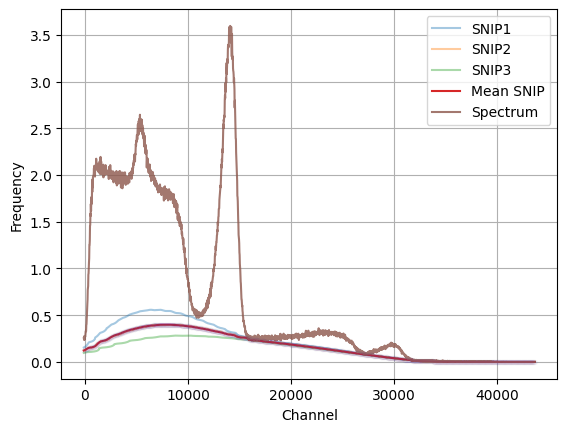

In [13]:
#Caricamento ed elaborazione spettro sodio

segnale_0cm = pd.read_csv(r'C:\Users\civig\Desktop\SiPM\Cristalli\Probabilities\new-na-0cm.CSV', sep=';', engine='python')
channel_0 = np.array(segnale_0cm['Channel'])
counts_0 = np.array(segnale_0cm['CSI'])

# calculating frequency and removing background noise via SNIP
frequency_0 = frequency_converter(counts_0, time_signal=1213)
background_0, err_background_0 = multi_SNIP_algorithm(frequency_0[0], channel_0, iterations=65, delta_n=10)

frequency_0 = (frequency_0[0] - background_0, np.sqrt(frequency_0[1]**2+err_background_0**2))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1014 (χ²/ndof = 4.2)       │              Nfcn = 727              │
│ EDM = 4.91e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  3.60e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ mu     │ 14.148e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma  │   536.1   │    3.3    │            │            │         │         │       │
│ 3 │ B      │  2.16e3   │  0.06e3   │            │            │         │         │       │
│ 4 │ mu2    │ 13.252e3  │  0.020e3  │            │            │         │         │       │
│ 5 │ sigma2 │    845    │     7     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │        A       mu    sigma        B      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│      A │ 3.42e+03     -191      166   -3.3e3   -1.1e3     -140 │
│     mu │     -191     19.5      -12      183       57       -8 │
│  sigma │      166      -12     10.6     -162      -53       -3 │
│      B │   -3.3e3      183     -162 3.32e+03    1.1e3      160 │
│    mu2 │   -1.1e3       57      -53    1.1e3      414       60 │
│ sigma2 │     -140       -8       -3      160       60       55 │
└────────┴───────────────────────────────────────────────────────┘

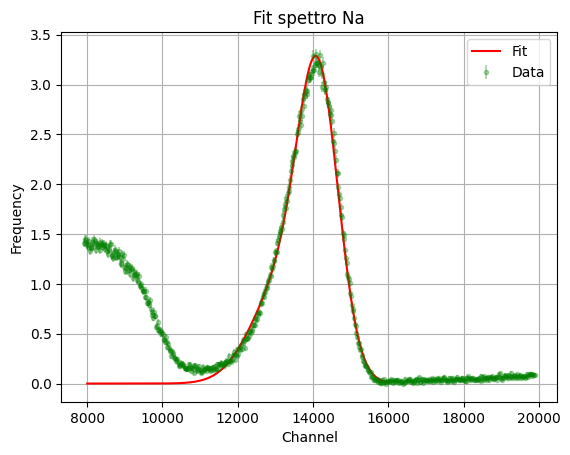

In [25]:
#Fit e plot
ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func)
m = Minuit(ls, A=5, mu=14300, sigma=400, B=2, mu2=12500, sigma2=100)
ls.mask = (channel_0 > 11000) & (channel_0 < 16000)
m.migrad()
m.hesse()
display(m)

xaxis = np.linspace(8000, 16000, 3000)
yaxis = func(xaxis, *m.values)
plt.errorbar(channel_0[400:1000], frequency_0[0][400:1000], frequency_0[1][400:1000], fmt='.', color='green', label='Data', alpha=0.3)
plt.plot(xaxis, yaxis, color='red', label='Fit')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fit spettro Na')
plt.grid()

In [26]:
#Calcolo con metodo trapezi
freq_integral = []
channel_integral = []
integral_extremes = [11500, 15800]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

In [28]:
total_amplitude = m.values["A"] + m.values["B"]
total_amplitude_err = np.sqrt(m.errors["A"]**2 + m.errors["B"]**2)

In [29]:
#Stampa risultati
print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {total_amplitude:.2f} ± {total_amplitude_err:.2f}')

Area picco con integrale trapezoidale: 5703.80
Area picco con integrale fit: 5760.11 ± 82.15
